# Optimize Final Model
As was determined in the previous notebook, the best performing model of the three was the pre-built Linear SVC model with an accuracy of 45% on the validation set. In this notebook, I will try to improve the model's performance through hyperparameter tuning and error analysis and will obtain a final accuracy score on the unseen testing dataset.

In [26]:
# import required libraries
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import metrics

## Import Training, Validation and Testing Datasets

In [2]:
# define the path for the processed datasets
PATH = "data/processed/"

# read the training dataset
hp_sentences_train = pd.read_csv(f"{PATH}training_df.csv")

# read the validation dataset
hp_sentences_val = pd.read_csv(f"{PATH}validation_df.csv")

# read the testing dataset
hp_sentences_test = pd.read_csv(f"{PATH}testing_df.csv")

In [3]:
# show the first 5 rows of the training dataset
hp_sentences_train.head()

,sentence,book
0,A wild-looking old woman dressed all in green ...,1
1,Harry was thinking about this time yesterday a...,1
2,"He had been down at Hagrid’s hut, helping him ...",1
3,"“We’re looking for a big, old-fashioned one — ...",1
4,I forbid you to tell the boy anything!” A brav...,1


In [4]:
# show the first 5 rows of the training dataset
hp_sentences_val.head()

,sentence,book
0,“She obviously makes more of an effort if you’...,1
1,We’ve eaten all our food and you still seem to...,1
2,"Please cheer up, Hagrid, we saved the Stone, i...",1
3,He gave his father a sharp tap on the head wit...,1
4,He kept threatening to tell her what really bi...,1


In [5]:
# show the first 5 rows of the training dataset
hp_sentences_test.head()

,sentence,book
0,"Excuse me, I’m a prefect!” “How could a troll ...",1
1,Harry wasn’t sure he could explain.,1
2,There was a tabby cat standing on the corner o...,1
3,"Peeves threw the chalk into a bin, which clang...",1
4,It didn’t so much as quiver when a car door sl...,1


## Load Linear SVC Model

In [6]:
# create a pipeline with the three steps required to train the classifier and make predictions
hp_classifier_svc = Pipeline([
    ('count_vect', CountVectorizer()), # create a word count vector
    ('freq_vect', TfidfTransformer()), # normalize the term frequencies
    ('classify', LinearSVC()) # use a Linear SVC classifier
])

In [7]:
# train the model on the sentences in the training dataset
hp_classifier_svc.fit(hp_sentences_train["sentence"], hp_sentences_train["book"])

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('freq_vect', TfidfTransformer()), ('classify', LinearSVC())])

In [8]:
# create new column in dataframe with the predicted book and measure how long it took in seconds
hp_sentences_val["LinearSVC"] = hp_classifier_svc.predict(hp_sentences_val["sentence"])

In [9]:
# show the first 5 rows of the validation dataset with the predictions
hp_sentences_val.head()

,sentence,book,LinearSVC
0,“She obviously makes more of an effort if you’...,1,7
1,We’ve eaten all our food and you still seem to...,1,1
2,"Please cheer up, Hagrid, we saved the Stone, i...",1,1
3,He gave his father a sharp tap on the head wit...,1,1
4,He kept threatening to tell her what really bi...,1,3


## Analyze errors
The first activity to improve the model's performance is to analyze the sentences that resulted in errors to identify patterns and modify the model consequentially. I will achieve this in the following three ways:
1. Assess the relationship between the length of a sentence and its accuracy.
2. Determine if some words/tokens are associated to a higher error rate.
3. Manually identify patterns in a sample of 50 errors.

### 1. Assess the relationship between the length of sentences and its accuracy

In [12]:
# extract the pre-process and tokenize functions from the pipelines
vectorizer = CountVectorizer()
preprocess = vectorizer.build_analyzer()

# add a column in the dataframe with the tokenized version of the sentence
hp_sentences_val["tokens"] = hp_sentences_val["sentence"].apply(preprocess)

hp_sentences_val.head()

,sentence,book,LinearSVC,tokens
0,“She obviously makes more of an effort if you’...,1,7,"[she, obviously, makes, more, of, an, effort, ..."
1,We’ve eaten all our food and you still seem to...,1,1,"[we, ve, eaten, all, our, food, and, you, stil..."
2,"Please cheer up, Hagrid, we saved the Stone, i...",1,1,"[please, cheer, up, hagrid, we, saved, the, st..."
3,He gave his father a sharp tap on the head wit...,1,1,"[he, gave, his, father, sharp, tap, on, the, h..."
4,He kept threatening to tell her what really bi...,1,3,"[he, kept, threatening, to, tell, her, what, r..."


In [17]:
# add a column in the dataframe with the lenght of the sentence
hp_sentences_val["length"] = hp_sentences_val["tokens"].apply(len)

# add a column in the dataframe that indicates if the prediction was accurate
hp_sentences_val["score"] = hp_sentences_val["book"] == hp_sentences_val["LinearSVC"]

hp_sentences_val.head()

,sentence,book,LinearSVC,tokens,length,score
0,“She obviously makes more of an effort if you’...,1,7,"[she, obviously, makes, more, of, an, effort, ...",20,False
1,We’ve eaten all our food and you still seem to...,1,1,"[we, ve, eaten, all, our, food, and, you, stil...",38,True
2,"Please cheer up, Hagrid, we saved the Stone, i...",1,1,"[please, cheer, up, hagrid, we, saved, the, st...",14,True
3,He gave his father a sharp tap on the head wit...,1,1,"[he, gave, his, father, sharp, tap, on, the, h...",13,True
4,He kept threatening to tell her what really bi...,1,3,"[he, kept, threatening, to, tell, her, what, r...",43,False


In [29]:
# determine the shortest and longest sentences
min_len = hp_sentences_val["length"].min()
max_len = hp_sentences_val["length"].max()

print(f"The shortest sentence has {min_len} tokens and the longest sentence has {max_len} tokens.")

The shortest sentence has 3 tokens and the longest sentence has 139 tokens.


In [55]:
# separate the sentences in 20 bins with approximately the same number of observations
hp_sentences_val["bin"] = pd.qcut(hp_sentences_val['length'], 20)

# verify that there are approximately the same number of observations in each bin
hp_sentences_val["bin"].value_counts()

(11.0, 13.0]     943
(15.0, 17.0]     783
(2.999, 5.0]     680
(18.0, 20.0]     660
(30.0, 35.0]     581
(7.0, 8.0]       576
(20.0, 22.0]     576
(24.0, 27.0]     572
(42.0, 139.0]    562
(6.0, 7.0]       550
(9.0, 10.0]      543
(8.0, 9.0]       542
(5.0, 6.0]       539
(10.0, 11.0]     522
(35.0, 42.0]     505
(22.0, 24.0]     464
(27.0, 30.0]     456
(14.0, 15.0]     439
(13.0, 14.0]     412
(17.0, 18.0]     364
Name: bin, dtype: int64

In [56]:
# create new dataframe with the total count and accurate predictions per bin
df_length_binned = hp_sentences_val.groupby("bin")["score"].agg(["count", "sum"]).rename(columns = {"sum": "accurate_predictions"}).reset_index()

# add a column with the accuracy score per bin
df_length_binned["accuracy_score"] = df_length_binned["accurate_predictions"] / df_length_binned["count"]

# add a column with the midpoint of the bin for plotting purposes
df_length_binned["bin_midpoint"] = df_length_binned["bin"].apply(lambda interval: round(interval.mid, 1))

# display the new dataframe
df_length_binned

,bin,count,accurate_predictions,accuracy_score,bin_midpoint
0,"(2.999, 5.0]",680,226,0.332353,4.0
1,"(5.0, 6.0]",539,187,0.346939,5.5
2,"(6.0, 7.0]",550,207,0.376364,6.5
3,"(7.0, 8.0]",576,228,0.395833,7.5
4,"(8.0, 9.0]",542,201,0.370849,8.5
5,"(9.0, 10.0]",543,214,0.394107,9.5
6,"(10.0, 11.0]",522,212,0.406130,10.5
7,"(11.0, 13.0]",943,389,0.412513,12.0
8,"(13.0, 14.0]",412,174,0.422330,13.5
9,"(14.0, 15.0]",439,188,0.428246,14.5


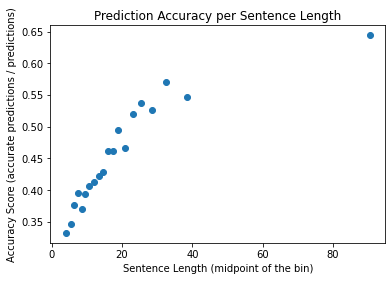

In [58]:
# visualize the accuracy score per length
fig, ax = plt.subplots()

x = df_length_binned["bin_midpoint"]
y = df_length_binned["accuracy_score"]

ax.scatter(x, y)

ax.set_title("Prediction Accuracy per Sentence Length")

plt.xlabel("Sentence Length (midpoint of the bin)")
plt.ylabel("Accuracy Score (accurate predictions / predictions)")

plt.show()

There is a clear positive relationship between the length of the sentence and the accuracy of the model. Restricting the testing to sentences of an arbitrary length would increase performance, but would not add value. Another potential resolution would be to utilize stemming to gain more context from less words.

### 2. Determine if some words/tokens are associated to a higher error rate.